# Testing VGG16
A tutorial to test LeNet-5 using ADAPT. This tutorial notebook is created with Ubuntu machine with Intel(R) i7-9700, GeForce RTX-2080, and 16GB of memory. Before start tutorial, if you use your GPU, the following cell will set tensorflow to use minimal memory.

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

## Load model to test
The pre-trained VGG-19 is offered by Tensorflow/Keras. You can easily download the pre-trained model using Tensorflow/Keras.

In [2]:
# from tensorflow.keras.applications.vgg19 import VGG16
# from tensorflow.keras.applications import ResNet50

In [3]:
# model2 = VGG16()
# Load the trained model
model = tf.keras.models.load_model('my_ResNet18model.keras')
# my_ResNet18model.keras

# model.summary()

## Test using ADAPT
From now on, let's test the created model.

### 1. Choose candidate input
This tutorial offers some example images in ```data/imagenet``` folder.

In [4]:
from pathlib import Path
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from datetime import datetime

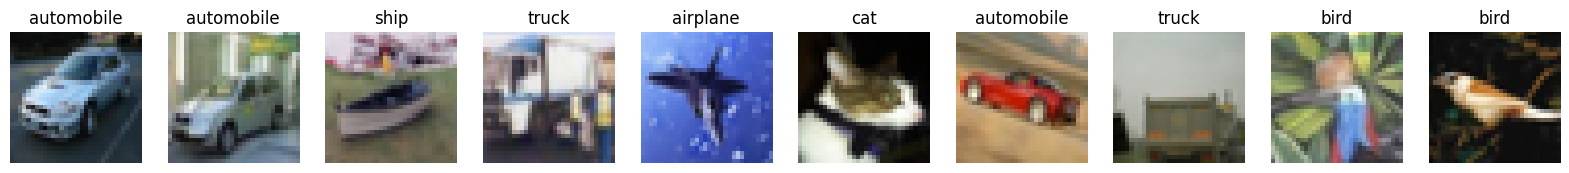

In [5]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Define class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']

# Select and plot a few test images
images = x_test[240:250]
# images = images.astype('float32') / 255.0
labels = y_test[240:250]

# Display the images
fig, ax = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
for i, img in enumerate(images):
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(class_labels[labels[i][0]])
plt.show()

Finally, preprocess the input using provided preprocess function.

Now our input image is ready!

### 2. Create a fuzzer
ADAPT offers various modules (e.g. coverage metrics and neuron selection strategies) that can be used to compose a fuzzer. First thing to do is wrapping Keras model, since all modules in ADAPT use a Keras model wrapped with the ```adapt.Network``` class.

In [6]:
from adapt import Network
import numpy as np

In [7]:
# model(x_test[0:2])
# # y_test[0:2]


In [8]:
from tensorflow.keras.models import Model
# functors = Model(inputs = model.input, outputs=[l.output for l in model.layers])


In [9]:
network = Network(model)

In [ ]:
# neurons = []
# for li, l in enumerate(network.layers):
#     for ni in range(l.output.shape[-1]):
#         neurons.append((li, ni))
# for li, l in enumerate(network.layers):
#     for ni in range(l.output.shape[-1]):
#         print("layer: " + str(l))
#         print("layer index: " + str(li))
#         print("neuron: " + str(ni))
# # neurons[6728]

images3 = images.astype('float32') / 255.0

In [11]:
# neurons[15936]
# neurons[6720]

In [12]:
# Evaluate the model
# from tensorflow.keras.utils import to_categorical
# x_test = x_test.astype('float32') / 255.0
# y_test = to_categorical(y_test, 10)
# test_loss, test_acc = model.evaluate(x_test, y_test)
# print(f'Test accuracy: {test_acc}')
# x_train


Create a tok-k neuron coverage with 30 as k value.

In [13]:
from adapt.metric import TKNC
from adapt.metric import NC

In [14]:
metric = NC(0.5)

Create an adaptive and parameterized neuron selection strategy introduced in the following paper:

    Effective White-Box Testing of Deep Neural Networks with Adaptive Neuron-Selection Strategy
    
Note that the selection strategies and the fuzzers are created for each indivisual input.

In [15]:
from adapt.strategy import AdaptiveParameterizedStrategy
from adapt.fuzzer import WhiteBoxFuzzer
from tensorflow.keras.applications.vgg19 import decode_predictions

In [16]:
images3 = images3[:2]
len(images3)

2

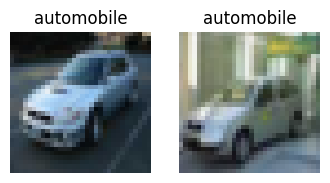

In [17]:
# Display the images
fig, ax = plt.subplots(1, len(images3), figsize=(len(images3) * 2, 2))
for i, img in enumerate(images3):
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(class_labels[labels[i][0]])
plt.show()

In [19]:
# test my strategy
from adapt.strategy import BayesStrategy

fuzzers_bayes = []
for image in images3:
    strategy = BayesStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, metric, strategy)
    fuzzers_bayes.append(fuzzer)

In [ ]:
print('Fuzzing with Bayes strategy started at {}.'.format(datetime.now()))
archives_bayes = [fuzzer.start(hours=12, append='min_dist') for fuzzer in fuzzers_bayes]
print('Done')

In [17]:
fuzzers_adapt = []
for image in images3:
    strategy = AdaptiveParameterizedStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, metric, strategy)
    fuzzers_adapt.append(fuzzer)

For comparision, fuzzers with random strategy, which selects neurons randomly, are used.

In [18]:
from adapt.strategy import RandomStrategy

In [19]:
fuzzers_rand = []
for image in images3:
    strategy = RandomStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, metric, strategy)
    fuzzers_rand.append(fuzzer)

### 3. Start testing
Each input is tested for 20 minutes (200 minutes in total for one strategy), and keep the generated inputs with minimum distances.

In [21]:
print('Fuzzing with adaptive parameterized strategy started at {}.'.format(datetime.now()))
archives_adapt = [fuzzer.start(minutes=3, append='min_dist') for fuzzer in fuzzers_adapt]
print('Done')

Fuzzing with adaptive parameterized strategy started at 2024-10-12 22:19:27.247144.
neurons: 
[(5, 96), (5, 10), (5, 6), (5, 11), (5, 94), (5, 12), (5, 13), (5, 14), (5, 95), (5, 42)]
neurons: 
[(5, 14), (17, 160), (17, 496), (5, 54), (18, 409), (5, 11), (13, 504), (18, 496), (19, 320), (5, 49)]
neurons: 
[(5, 100), (5, 49), (5, 13), (17, 264), (5, 42), (17, 249), (5, 85), (5, 20), (5, 81), (5, 70)]
neurons: 
[(5, 81), (5, 33), (5, 101), (5, 96), (17, 129), (17, 54), (5, 68), (5, 125), (2, 25), (17, 249)]
neurons: 
[(5, 54), (17, 406), (18, 406), (17, 365), (17, 362), (5, 14), (5, 125), (5, 86), (5, 0), (5, 82)]
neurons: 
[(17, 92), (17, 449), (5, 42), (18, 449), (17, 271), (18, 507), (5, 102), (5, 49), (17, 253), (5, 96)]
neurons: 
[(17, 392), (17, 12), (17, 92), (18, 392), (5, 49), (5, 96), (5, 68), (19, 426), (5, 76), (5, 101)]
neurons: 
[(5, 76), (18, 282), (5, 101), (5, 19), (17, 207), (5, 54), (17, 282), (5, 63), (5, 68), (5, 11)]
neurons: 
[(5, 49), (5, 42), (5, 96), (5, 101), (

In [22]:
print('Fuzzing with random strategy started at {}.'.format(datetime.now()))
archives_rand = [fuzzer.start(minutes=3, append='min_dist') for fuzzer in fuzzers_rand]
print('Done')

Fuzzing with random strategy started at 2024-10-12 22:11:05.925797.
count380
count359
Done


### 4. Testing result
Here is the coverage graph.

In [58]:
import numpy as np

In [28]:
image_idx = 1
times = range(len(archives_bayes[image_idx].timestamp))
# adapt
coverage = []
for t, cov in archives_adapt[image_idx].timestamp:
    coverage.append(cov)
plt.plot(times, coverage[:len(archives_bayes[image_idx].timestamp)], label='adapt')

#bayes 
coverage = []
for t, cov in archives_rand[image_idx].timestamp:
    coverage.append(cov)
plt.plot(times, coverage[:len(archives_bayes[image_idx].timestamp)], label='random')

#bayes 
# coverage = []
# for t, cov in archives_bayes[image_idx].timestamp:
#     coverage.append(cov)
# plt.plot(times, coverage[:len(archives_bayes[image_idx].timestamp)], label='bayes')

plt.suptitle('VGG16')
plt.legend()
plt.show()

NameError: name 'archives_bayes' is not defined

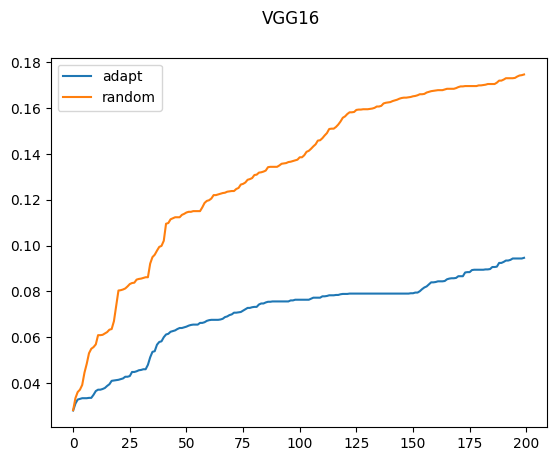

In [28]:
image_idx = 0
times = range(200)
# adapt
coverage = []
for t, cov in archives_adapt[image_idx].timestamp:
    coverage.append(cov)
plt.plot(times, coverage[:200], label='adapt')

#bayes 
coverage = []
for t, cov in archives_rand[image_idx].timestamp:
    coverage.append(cov)
plt.plot(times, coverage[:200], label='random')

#bayes 
# coverage = []
# for t, cov in archives_bayes[image_idx].timestamp:
#     coverage.append(cov)
# plt.plot(times, coverage[:len(archives_bayes[image_idx].timestamp)], label='bayes')

plt.suptitle('VGG16')
plt.legend()
plt.show()

In [27]:
times = list(range(50))
coverages = []
for archive in archives_adapt:
    coverage = []
    timestamp = iter(archive.timestamp)
    t, cov = next(timestamp)
    for current_t in times:
        while current_t > t:
            t, cov = next(timestamp)
        coverage.append(cov)
    coverages.append(coverage)
coverages = np.mean(coverages, axis=0)
plt.plot(times, coverages, label='adapt')
coverages = []
for archive in archives_rand:
    coverage = []
    timestamp = iter(archive.timestamp)
    t, cov = next(timestamp)
    for current_t in times:
        while current_t > t:
            t, cov = next(timestamp)
        coverage.append(cov)
    coverages.append(coverage)
coverages = np.mean(coverages, axis=0)
print(len(coverages))
plt.plot(times, coverages, label='rand')
plt.suptitle('vgg19')
plt.legend()
plt.show()

StopIteration: 

Archive classes stores all the testing result. You can easily see the testing result by following command.

In [26]:
archives_adapt[0].summary()

----------
Total inputs: 254
  Average distance: 0.23280003666877747
Total adversarials: 96
  Average distance: 0.25939345359802246
Error rate: 
0.3779527559055118
Coverage
  Original: 0.028083209509658247
  Achieved: 0.09717682020802378
----------
Original label: 6
  Count: 158
  Average distance: 0.21664202213287354
----------
Label: 2
  Count: 5
  Average distance: 0.25882530212402344
----------
Label: 3
  Count: 48
  Average distance: 0.27409827709198
----------
Label: 1
  Count: 40
  Average distance: 0.23804569244384766
----------
Label: 5
  Count: 2
  Average distance: 0.326276957988739
----------
Label: 4
  Count: 1
  Average distance: 0.27654406428337097
----------


In [22]:
archives_bayes[1].summary()

----------
Total inputs: 372
  Average distance: 0.10891470313072205
Total adversarials: 221
  Average distance: 0.11374571174383163
Error rate: 
0.5940860215053764
Coverage
  Original: 0.43584598018311804
  Achieved: 0.8002633889376646
----------
Original label: 1
  Count: 151
  Average distance: 0.10184416174888611
----------
Label: 9
  Count: 51
  Average distance: 0.11889883130788803
----------
Label: 3
  Count: 107
  Average distance: 0.10687681287527084
----------
Label: 6
  Count: 60
  Average distance: 0.12074160575866699
----------
Label: 5
  Count: 3
  Average distance: 0.13121633231639862
----------


In [33]:
archives_rand[0].summary()

----------
Total inputs: 478
  Average distance: 0.17556080222129822
Total adversarials: 390
  Average distance: 0.18419882655143738
Error rate: 
0.8158995815899581
Coverage
  Original: 0.10520059435364042
  Achieved: 0.41426448736998517
----------
Original label: 3
  Count: 88
  Average distance: 0.13727857172489166
----------
Label: 6
  Count: 139
  Average distance: 0.17060969769954681
----------
Label: 8
  Count: 58
  Average distance: 0.17388881742954254
----------
Label: 5
  Count: 88
  Average distance: 0.17810828983783722
----------
Label: 9
  Count: 9
  Average distance: 0.19255012273788452
----------
Label: 1
  Count: 50
  Average distance: 0.20463331043720245
----------
Label: 0
  Count: 25
  Average distance: 0.2048315405845642
----------
Label: 7
  Count: 16
  Average distance: 0.2679970860481262
----------
Label: 2
  Count: 4
  Average distance: 0.20649650692939758
----------
Label: 4
  Count: 1
  Average distance: 0.1643681824207306
----------


Plus, the following is a visualization of some generated images.

In [119]:
for i, label in enumerate(archives_adapt):
    archives_adapt[i].summary()

----------
Total inputs: 764
  Average distance: 0.011514723300933838
Total adversarials: 0
  Average distance: -
Coverage
  Original: 0.04562236286919831
  Achieved: 0.08122362869198312
----------
Original label: house_finch
  Count: 764
  Average distance: 0.011514723300933838
----------
----------
Total inputs: 796
  Average distance: 0.028308581560850143
Total adversarials: 110
  Average distance: 0.05663487687706947
Coverage
  Original: 0.045490506329113924
  Achieved: 0.084915611814346
----------
Original label: Pomeranian
  Count: 686
  Average distance: 0.02376646175980568
----------
Label: cairn
  Count: 110
  Average distance: 0.05663487687706947
----------


In [118]:
len(archives_adapt[1].found_labels)

2

In [48]:
archives_adapt[0].inputs[5][0]

array([[[[0.6200982 , 0.4383222 , 0.18988357],
         [0.6345563 , 0.44539675, 0.19028227],
         [0.65835994, 0.4626302 , 0.20284364],
         ...,
         [0.53556097, 0.3729905 , 0.13783184],
         [0.49530113, 0.36121395, 0.14184038],
         [0.45458096, 0.3350895 , 0.12917802]],

        [[0.6015227 , 0.4409732 , 0.20015568],
         [0.61081797, 0.44530654, 0.16523474],
         [0.63899565, 0.45389298, 0.1762518 ],
         ...,
         [0.5329128 , 0.37441772, 0.11703984],
         [0.49470586, 0.36650088, 0.1284048 ],
         [0.46691695, 0.3488622 , 0.13342805]],

        [[0.5864294 , 0.41473857, 0.16837835],
         [0.5951103 , 0.41504252, 0.11465082],
         [0.62792933, 0.42614734, 0.12717369],
         ...,
         [0.5408855 , 0.3778127 , 0.12050469],
         [0.51045793, 0.37722287, 0.1296122 ],
         [0.46877742, 0.35089093, 0.12628707]],

        ...,

        [[0.26979488, 0.494221  , 0.69483596],
         [0.16700912, 0.40173027, 0.5758732 ]

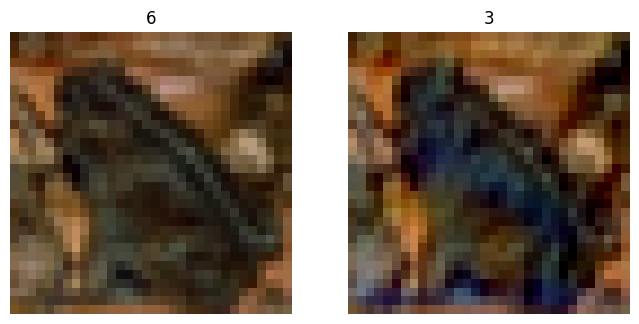

In [42]:
imageIDX = 0
fig, ax = plt.subplots(1, len(archives_adapt[imageIDX].found_labels), figsize=(len(archives_adapt[imageIDX].found_labels) * 4, 4))

if len(archives_adapt[imageIDX].found_labels) == 1:
    ax = [ax]

for i, label in enumerate(archives_adapt[imageIDX].found_labels.keys()):
    ax[i].set_axis_off()
    ax[i].title.set_text(str(label))
    # ax[i].set_title(class_labels[labels[imageIDX][0]])

    # Remove extra dimension using squeeze()
    im = np.array(archives_adapt[imageIDX].inputs[label][0]).squeeze()
    im = (im * 255).clip(0, 255)  # Rescale if values are between 0 and 1
    ax[i].imshow(im.astype(int))

    ax[i].imshow(im.astype(int))

plt.show()


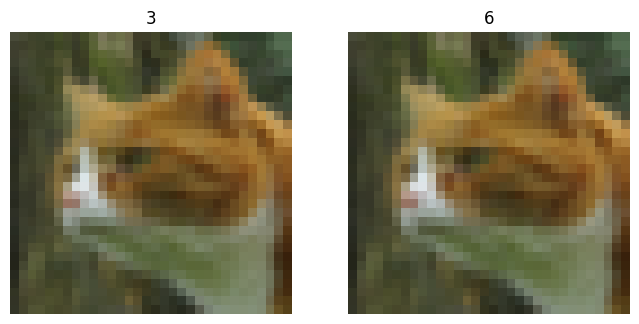

In [25]:
imageIDX = 1
fig, ax = plt.subplots(1, len(archives_bayes[imageIDX].found_labels), figsize=(len(archives_bayes[imageIDX].found_labels) * 4, 4))

if len(archives_bayes[imageIDX].found_labels) == 1:
    ax = [ax]

for i, label in enumerate(archives_bayes[imageIDX].found_labels.keys()):
    ax[i].set_axis_off()
    ax[i].title.set_text(str(label))

    # Remove extra dimension using squeeze()
    im = np.array(archives_bayes[imageIDX].inputs[label][0]).squeeze()
    im = (im * 255).clip(0, 255)  # Rescale if values are between 0 and 1
    ax[i].imshow(im.astype(int))


    ax[i].imshow(im.astype(int))

plt.show()


In [45]:
archives_adapt[0].inputs[3][0].shape

(1, 32, 32, 3)

In [30]:
overallMSE = []
# traverse all test images
for image in range(len(archives_adapt)):
    original_ssim = archives_adapt[image].mse
    # filter the correct label image
    filtered_ssim = [x for x in original_ssim if x != -1]
    #  store avg SSIM for one image
    overallMSE.append(np.mean(filtered_ssim))
#  calculate avg SSIM for all images
overallMSE = np.mean(overallMSE)
print("The average MSE of Adapt is: ")
print(overallMSE)

The average MSE of Adapt is: 
0.0012435907626507986


In [48]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Ensure both images have the same shape
originalImg = np.reshape(images[0], (32, 32, 3))
generatedImg = np.reshape(archives_adapt[0].inputs[6][0], (32, 32, 3))

# Calculate SSIM with an appropriate window size for 32x32 images
score = ssim(originalImg, generatedImg, data_range=1.0, channel_axis=2, win_size=5)

print(f"SSIM between the original and Adapt adversarial image: {score}")


SSIM between the original and Adapt adversarial image: 6.779305809320056e-05


In [23]:
import pickle
from datetime import datetime

# Get the current time
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Create the file name with the current time
file_name = f'CIFAR10_res_240_{current_time}'
# open a file, where you ant to store the data
file = open(file_name, 'wb')

# dump information to that file
pickle.dump(archives_bayes, file)

# close the file
file.close()